In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
from scipy.stats import chi2_contingency
%matplotlib inline
import numpy as np
import seaborn as sns
import igraph as ig
from scipy.spatial.distance import cdist
import netplotbrain
from nilearn import datasets
from nilearn import plotting
import numpy as np
from brainspace.plotting import plot_hemispheres, surface_plotting
from brainstat.datasets import fetch_mask, fetch_template_surface,fetch_parcellation
import nibabel as nib
from IPython.display import display, Image


In [6]:
DIR=os.path.join("/NAS","tupac","protocoles","PULSE")

In [7]:
#lecture des fichiers excels
df_part = pd.read_excel(os.path.join(DIR,'Liste_participants.xlsx'))
df_cort = pd.read_excel(os.path.join(DIR,'valeurs_corticales_glasser360.xlsx'))
df_sscor2 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_keuken7T.xlsx'))
df_sscor1 = pd.read_excel(os.path.join(DIR,'valeurs_sous_corticales_Volbrain.xlsx'))

In [8]:
df_roi = pd.read_csv(os.path.join(DIR,'Coord_ROI_atlas_inMNI.csv'))
df_roi = df_roi.drop('Name_inPulse', axis=1)
df_roi.set_index('Name_inAtlas', inplace=True)
df_roi

,X,Y,Z
Name_inAtlas,,,
R_amygdala,22.286025,-4.068067,-19.733526
L_amygdala,-21.742625,-5.337021,-19.808260
R_caudate,13.781250,10.302004,9.587786
L_caudate,-12.909930,9.549651,9.286178
R_hippocampus,26.481760,-21.424464,-13.697425
...,...,...,...
L_STSva,-52.357733,-9.350649,-16.895514
L_TE1m,-64.656484,-26.864331,-14.723270
L_PI,-44.851888,-4.322362,-13.133591


In [9]:
[col[8:] for col in df_cort.filter(regex="Mediane").columns]

['Right_V1',
 'Right_MST',
 'Right_V6',
 'Right_V2',
 'Right_V3',
 'Right_V4',
 'Right_V8',
 'Right_4',
 'Right_3b',
 'Right_FEF',
 'Right_PEF',
 'Right_55b',
 'Right_V3A',
 'Right_RSC',
 'Right_POS2',
 'Right_V7',
 'Right_IPS1',
 'Right_FFC',
 'Right_V3B',
 'Right_LO1',
 'Right_LO2',
 'Right_PIT',
 'Right_MT',
 'Right_A1',
 'Right_PSL',
 'Right_SFL',
 'Right_PCV',
 'Right_STV',
 'Right_7Pm',
 'Right_7m',
 'Right_POS1',
 'Right_23d',
 'Right_v23ab',
 'Right_d23ab',
 'Right_31pv',
 'Right_5m',
 'Right_5mv',
 'Right_23c',
 'Right_5L',
 'Right_24dd',
 'Right_24dv',
 'Right_7AL',
 'Right_SCEF',
 'Right_6ma',
 'Right_7Am',
 'Right_7PL',
 'Right_7PC',
 'Right_LIPv',
 'Right_VIP',
 'Right_MIP',
 'Right_1',
 'Right_2',
 'Right_3a',
 'Right_6d',
 'Right_6mp',
 'Right_6v',
 'Right_p24pr',
 'Right_33pr',
 'Right_a24pr',
 'Right_p32pr',
 'Right_a24',
 'Right_d32',
 'Right_8BM',
 'Right_p32',
 'Right_10r',
 'Right_47m',
 'Right_8Av',
 'Right_8Ad',
 'Right_9m',
 'Right_8BL',
 'Right_9p',
 'Right_10d

In [10]:
#Mise à jour des index
df_sscor1.set_index('Participant', inplace=True)
df_sscor2.set_index('SUBJID', inplace=True)
df_cort.set_index('SUBJID', inplace=True)
df_part.set_index('participant_id', inplace=True)

In [11]:
#création de data #filter(regex="R2")
data=df_sscor1.filter(regex="Mediane").join(df_sscor2.filter(regex="Mediane")).join(df_cort.filter(regex="Mediane"))
data.columns=df_roi.index
print(data.shape)
nozero_cols = data.columns[data.all()]
data=data[nozero_cols]
df_roi=df_roi.loc[nozero_cols.values]
print(data.shape)

(181, 384)
(181, 333)


In [12]:
cols_index = list(range(24))
cols_names = ['R_4', 'L_4']
cols_to_keep = cols_index + [data.columns.get_loc(name) for name in cols_names]
print(cols_to_keep)
print(data.columns[cols_to_keep])
data = data.iloc[:, cols_to_keep]
df_roi = df_roi.iloc[cols_to_keep,:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 27, 164]
Index(['R_amygdala', 'L_amygdala', 'R_caudate', ' L_caudate', 'R_hippocampus',
       'L_hippocampus', 'R_pallidum', 'L_pallidum', 'R_putamen', 'L_putamen',
       'R_thalamus', 'L_thalamus', 'R_anterior insula', 'L_anterior insula',
       'R_posterior insula', 'L_posterior insula', 'L_RN', 'L_SN', 'L_GPe',
       'L_GPi', 'R_RN', 'R_SN', 'R_GPe', 'R_GPi', 'R_4', 'L_4'],
      dtype='object', name='Name_inAtlas')


In [13]:
df=df_part[['Declin','AGE','SEXE','SITE_APP','Score_de_declin']].dropna().join(data)
df=df.dropna()

In [14]:
def combine_gp(row):
    return row['SITE_APP'] + '_' + row['Declin']

df['Site_declin'] = df.apply(combine_gp, axis=1)

In [16]:
df = df.rename(columns=lambda x: x.replace("Mediane ", ""))

In [48]:
mask = fetch_mask("fsaverage5")
inflated_left, inflated_right = fetch_template_surface("fsaverage5",layer="inflated",join=False)
glasser = fetch_parcellation("fsaverage5", "glasser", 360)

# Carte corticale de chaque phenotype

/home/global/Anaconda3-2023.09/lib/python3.11/site-packages/brainspace/vtk_interface/wrappers/data_object.py:166: UserWarning: Input array is boolean. Casting to uint8.
  warnings.warn('Input array is boolean. Casting to uint8.')


32 ['Bulbaire_Fast']


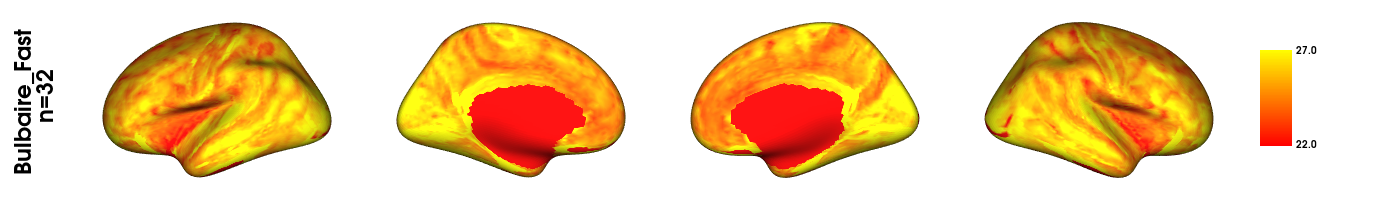

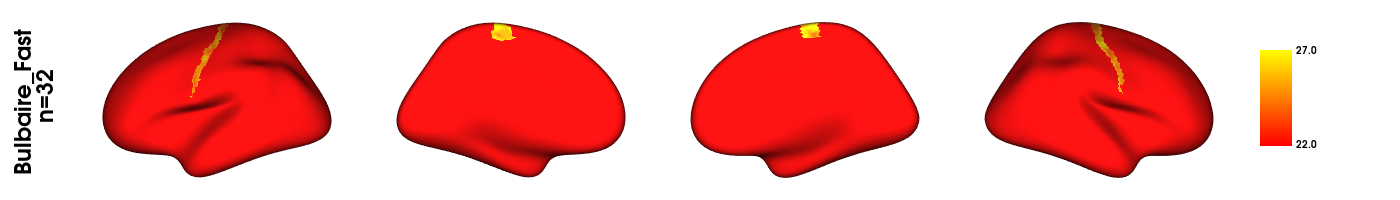

7 ['Bulbaire_Slow']


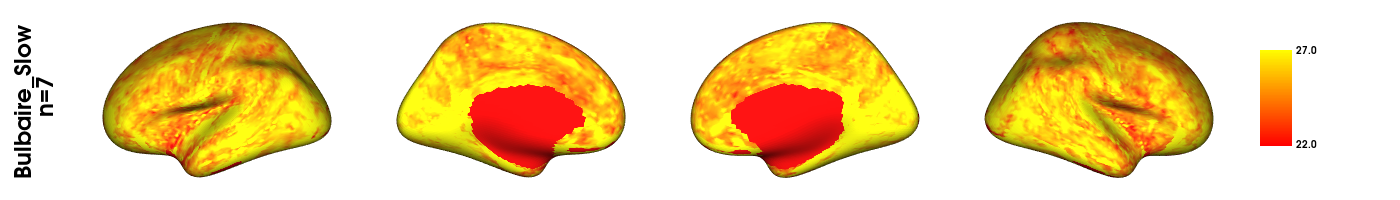

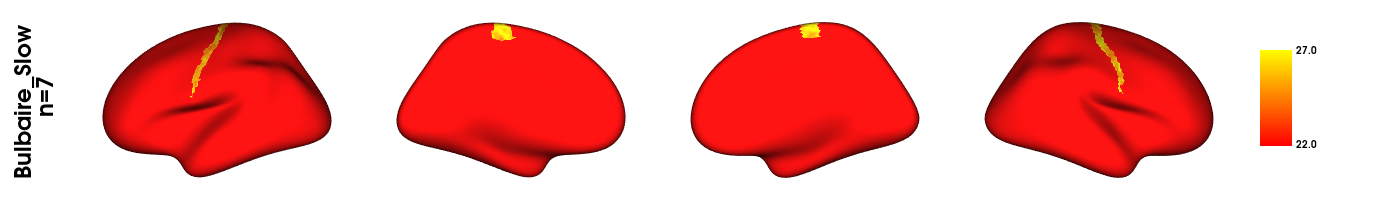

30 ['Membre inférieur_Fast']


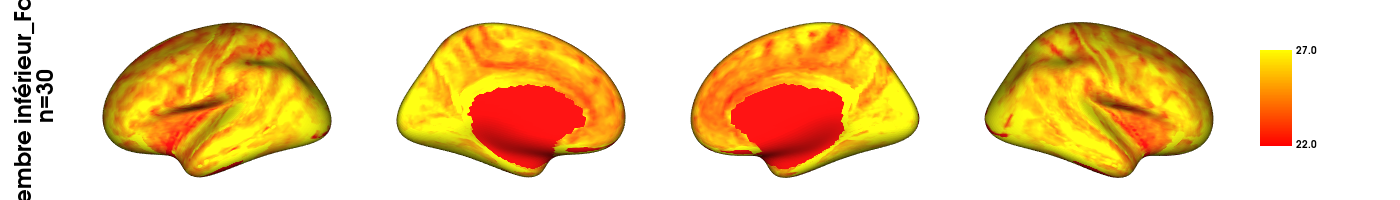

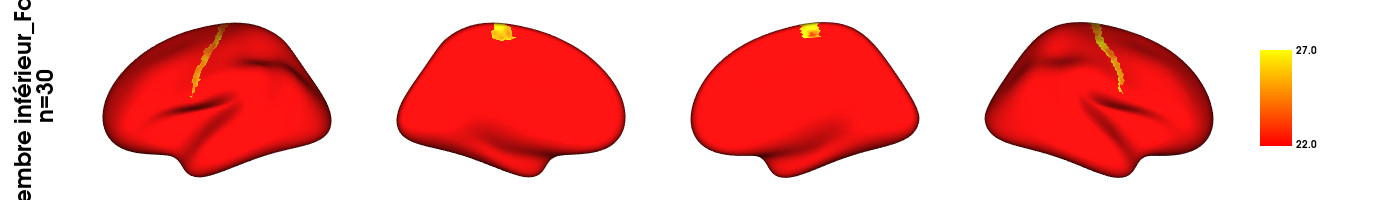

30 ['Membre inférieur_Slow']


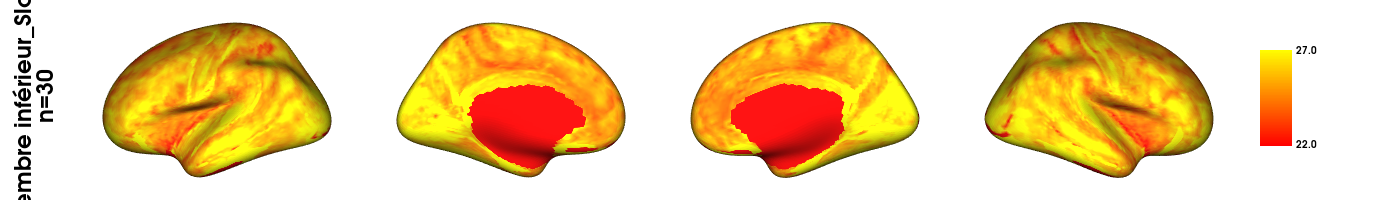

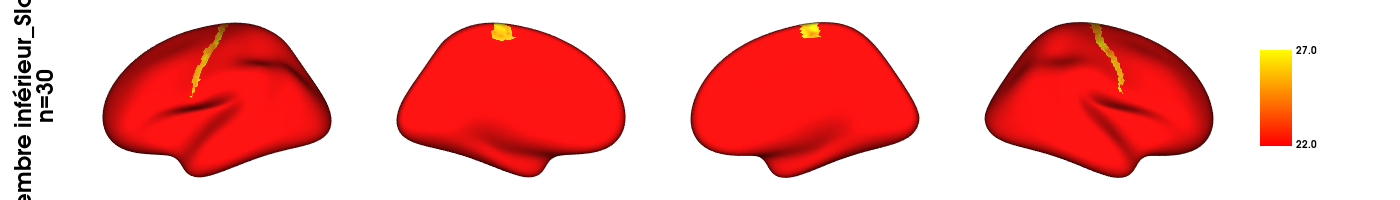

32 ['Membre supérieur_Fast']


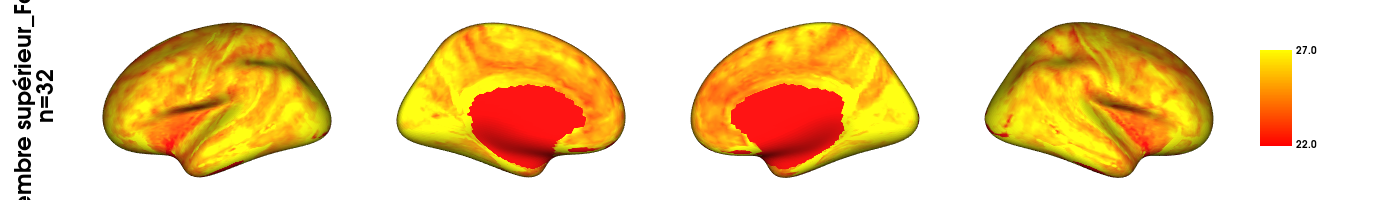

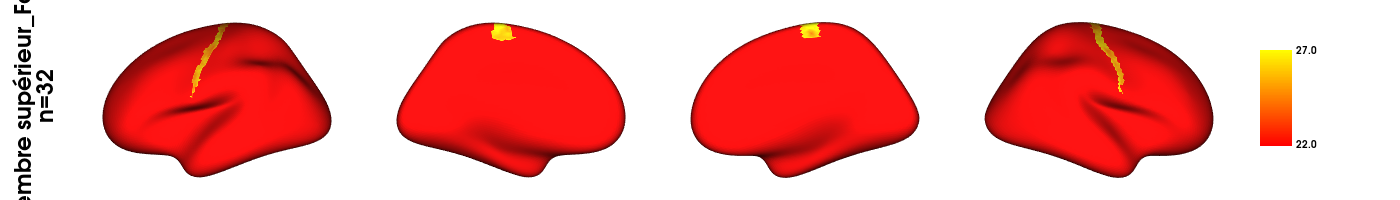

42 ['Membre supérieur_Slow']


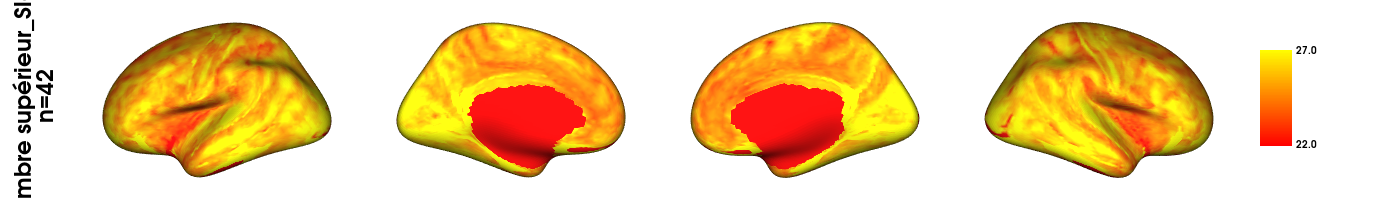

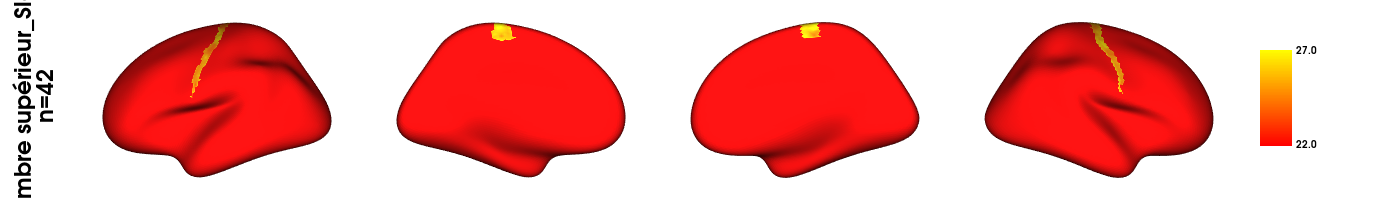

In [118]:
mask_4=(glasser==8) | (glasser==188) & mask
plot_hemispheres(inflated_left,inflated_right,glasser==4, color_bar=True,
        label_text=["Glasser"], cmap="jet", 
        embed_nb=True, size=(1400, 400), zoom=1.2, nan_color=(0.7, 0.7, 0.7, 1), 
        cb__labelTextProperty={"fontSize": 12},transparent_bg=False, interactive=False)
for GROUP in np.unique(df['Site_declin']):
    array_test = np.arange(40968)
    R2 = array_test.reshape(2,-1)
    df_perm=df.loc[df['Site_declin']==GROUP];   
    print(len(df_perm),np.unique(df_perm['Site_declin']))
    for SUBJ in df_perm.index:
        R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{SUBJ}_L_projection.func.gii")
        R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{SUBJ}_R_projection.func.gii")

        R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
        R2 = np.vstack([R2,R2_tot])

    tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.99))
    figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","screenshots",f"R2_nilearn_{GROUP}.png")
    plot_hemispheres(inflated_left, inflated_right,(np.median(tmp_c,axis=0))*mask, 
                    color_bar = True, color_range=(22,27),label_text=[f"{GROUP} \n n={len(df_perm)}"], 
                    cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                    cb__labelTextProperty={"fontSize": 10},screenshot=True, filename = figure_title,
                    interactive= False, transparent_bg = False)
    display(Image(filename=figure_title))
    figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","screenshots",f"R2_nilearn_{GROUP}_masked.png")
    plot_hemispheres(inflated_left, inflated_right,(np.median(tmp_c,axis=0))*mask_4, 
                    color_bar = True, color_range=(22,27),label_text=[f"{GROUP} \n n={len(df_perm)}"], 
                    cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                    cb__labelTextProperty={"fontSize": 10},screenshot=True, filename = figure_title,
                    interactive= False, transparent_bg = False)
    display(Image(filename=figure_title))

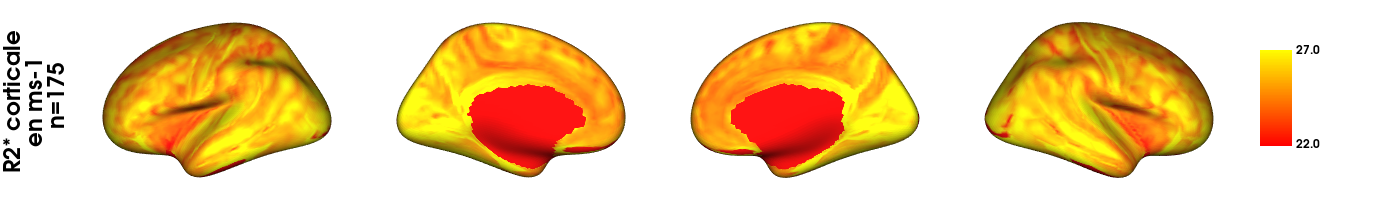

In [119]:
#df_sscor1.filter(regex="Mediane")
array_test = np.arange(40968)
R2 = array_test.reshape(2,-1)
for row in df.index:
    if row == "15001GCP" or row == "15003FMP" or row == "15004CAP":
        continue
    R2_l = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_L_projection.func.gii")
    R2_r = nib.load(f"/NAS/tupac/protocoles/PULSE/MNI152/Projections/sub-{row}_R_projection.func.gii")

    R2_tot=np.concatenate([R2_l.agg_data(),R2_r.agg_data()],axis=0)
    R2 = np.vstack([R2,R2_tot])

tmp_c=np.clip(R2,np.quantile(R2,0),np.quantile(R2,0.90))
figure_title=os.path.join("/NAS","tupac","protocoles","PULSE","screenshots","R2_nilearn_FullPopulation.png")
plot_hemispheres(inflated_left, inflated_right,(np.mean(tmp_c,axis=0))*mask, 
                 color_bar = True, color_range=(22,27),label_text=[f"R2* corticale \n en ms-1  \n n={R2.shape[0]}"], 
                 cmap = "autumn", embed_nb=True, size=(1400,200), zoom=1.45, 
                 cb__labelTextProperty={"fontSize": 12},screenshot=True, filename = figure_title,
                 interactive= False, transparent_bg = False)
display(Image(filename=figure_title))

# Stats descriptives

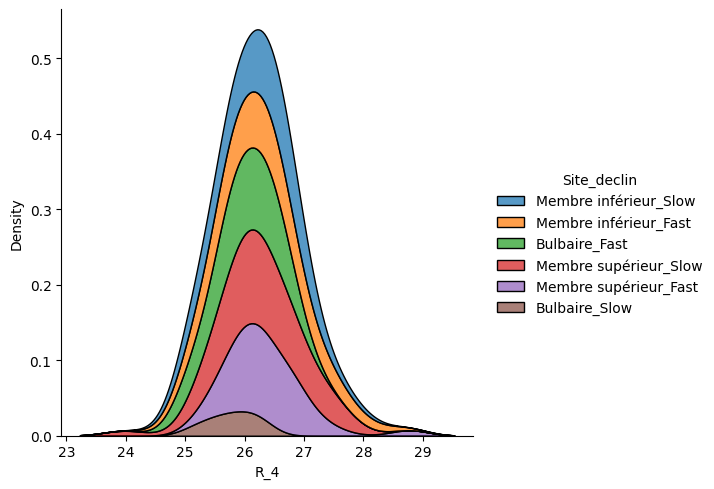

In [26]:
# Visualisation de la différence de distribution de la variable "amygdale" entre les classes de "declin"
sns.displot(data=df, x="R_4", hue="Site_declin", kind="kde", multiple="stack")

In [81]:
pd.pivot_table(df, values=["AGE","Score_de_declin","L_hippocampus","R_4"],  columns=["Site_declin"],aggfunc=["mean","min","max"],)

mean                                      \
Site_declin     Bulbaire_Fast Bulbaire_Slow Membre inférieur_Fast   
AGE                 63.656250     60.000000             63.766667   
L_hippocampus       24.126967     23.935859             24.981528   
R_4                 25.986743     25.794728             26.346782   
Score_de_declin      1.381761      0.320413              1.180134   

                                                             \
Site_declin     Membre inférieur_Slow Membre supérieur_Fast   
AGE                         59.300000             57.656250   
L_hippocampus               24.355471             24.763542   
R_4                         26.266791             26.382680   
Score_de_declin              0.331649              1.368508   

                                                min                \
Site_declin     Membre supérieur_Slow Bulbaire_Fast Bulbaire_Slow   
AGE                         58.595238     46.000000     51.000000   
L_hippocampus               24.608546     22.551490     22.466102   
R_4                         26.260825     24.937572     25.168518   
Score_de_declin              0.326486      0.610315      0.030173   

                                                             \
Site_declin     Membre inférieur_Fast Membre inférieur_Slow   
AGE                         44.000000             35.000000   
L_hippocampus               23.369864             23.217559   
R_4                         24.914558             24.962898   
Score_de_declin              0.605263              0.086074   

                                                                      max  \
Site_declin     Membre supérieur_Fast Membre supérieur_Slow Bulbaire_Fast   
AGE                         38.000000          3.700000e+01     79.000000   
L_hippocampus               22.278664          2.305408e+01     25.501065   
R_4                         25.362440          2.397844e+01     27.012464   
Score_de_declin              0.658527          2.925695e-18      4.428571   

                                                                           \
Site_declin     Bulbaire_Slow Membre inférieur_Fast Membre inférieur_Slow   
AGE                 75.000000             86.000000             78.000000   
L_hippocampus       25.464141             27.611450             26.961339   
R_4                 26.260170             28.334197             27.852598   
Score_de_declin      0.586667              3.500000              0.579255   

                                                             
Site_declin     Membre supérieur_Fast Membre supérieur_Slow  
AGE                         77.000000             86.000000  
L_hippocampus               27.702966             28.651141  
R_4                         28.779740             27.803903  
Score_de_declin              4.750000              0.583333

In [127]:
func = lambda x: 100*x.count()/df.shape[0]
table=pd.pivot_table(df, values=["AGE"],  columns=["Site_declin"],aggfunc=["mean","std","min","max"])
print(table.T)
#pd.crosstab(df, values=["SEXE"],  columns=["Site_declin"],aggfunc=["count"])

                                  AGE
     Site_declin                     
mean Bulbaire_Fast          63.656250
     Bulbaire_Slow          60.000000
     Membre inférieur_Fast  63.766667
     Membre inférieur_Slow  59.300000
     Membre supérieur_Fast  57.656250
     Membre supérieur_Slow  58.595238
std  Bulbaire_Fast           8.426568
     Bulbaire_Slow           8.000000
     Membre inférieur_Fast  11.211704
     Membre inférieur_Slow  11.697775
     Membre supérieur_Fast  11.087946
     Membre supérieur_Slow  12.466657
min  Bulbaire_Fast          46.000000
     Bulbaire_Slow          51.000000
     Membre inférieur_Fast  44.000000
     Membre inférieur_Slow  35.000000
     Membre supérieur_Fast  38.000000
     Membre supérieur_Slow  37.000000
max  Bulbaire_Fast          79.000000
     Bulbaire_Slow          75.000000
     Membre inférieur_Fast  86.000000
     Membre inférieur_Slow  78.000000
     Membre supérieur_Fast  77.000000
     Membre supérieur_Slow  86.000000


In [128]:
df

,Declin,AGE,SEXE,SITE_APP,Score_de_declin,R_amygdala,L_amygdala,R_caudate,L_caudate,R_hippocampus,...,L_SN,L_GPe,L_GPi,R_RN,R_SN,R_GPe,R_GPi,R_4,L_4,Site_declin
participant_id,,,,,,,,,,,,,,,,,,,,,
01005AGP,Slow,51,M,Membre inférieur,0.316186,26.198459,25.593589,26.048285,25.771546,26.041669,...,33.770030,236.597617,28.220165,15.862676,22.544765,42.618568,27.371493,26.591126,27.312667,Membre inférieur_Slow
01006SCP,Slow,55,M,Membre inférieur,0.088537,23.831634,23.575501,26.811122,26.708317,24.803066,...,41.862425,8.869263,6.549591,7.713252,25.259148,19.948511,13.536101,26.244127,26.143306,Membre inférieur_Slow
01007LAP,Fast,63,F,Membre inférieur,0.741379,24.135123,24.615499,27.129291,27.983717,24.159110,...,35.382676,143.896731,38.637553,9.398683,40.080831,121.330293,12.075051,25.303460,25.470009,Membre inférieur_Fast
01008LBP,Fast,53,F,Bulbaire,1.018623,24.735790,26.049833,26.838183,28.201485,24.495157,...,31.316284,37.062941,12.483427,58.413561,21.358205,237.507904,14.318242,26.095170,24.654586,Bulbaire_Fast
01010DCP,Slow,60,M,Membre supérieur,0.170638,23.726024,23.124884,30.222176,27.671232,23.826502,...,50.010365,73.180058,23.381137,18.257997,69.357310,63.758309,11.878822,26.671448,26.029613,Membre supérieur_Slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19035SPP,Slow,59,M,Membre supérieur,0.333333,22.496495,23.886183,29.074727,28.861689,24.454439,...,5.129962,938.319928,531.915712,10.816277,4.002551,1200.282942,1313.453547,27.506173,25.874207,Membre supérieur_Slow
19036CJP,Fast,73,F,Membre inférieur,0.681200,22.167099,23.370389,27.031612,27.846520,23.750106,...,18.123465,8.366929,3.919002,12.640865,9.201527,11.372819,4.228097,27.309789,27.086159,Membre inférieur_Fast
19037GHP,Slow,65,M,Membre inférieur,0.183707,27.047280,25.539510,26.865910,26.549033,26.154003,...,43.549630,121.434509,99.355858,8.951233,27.976917,61.129755,112.799700,27.852598,26.960588,Membre inférieur_Slow


In [129]:
table=pd.pivot_table(df, values=["Score_de_declin"],  columns=["Site_declin"],aggfunc=["mean","std","min","max"])
print(table.T)

                            Score_de_declin
     Site_declin                           
mean Bulbaire_Fast             1.381761e+00
     Bulbaire_Slow             3.204130e-01
     Membre inférieur_Fast     1.180134e+00
     Membre inférieur_Slow     3.316492e-01
     Membre supérieur_Fast     1.368508e+00
     Membre supérieur_Slow     3.264859e-01
std  Bulbaire_Fast             9.061906e-01
     Bulbaire_Slow             2.185843e-01
     Membre inférieur_Fast     7.079761e-01
     Membre inférieur_Slow     1.656869e-01
     Membre supérieur_Fast     9.833911e-01
     Membre supérieur_Slow     1.677640e-01
min  Bulbaire_Fast             6.103152e-01
     Bulbaire_Slow             3.017271e-02
     Membre inférieur_Fast     6.052632e-01
     Membre inférieur_Slow     8.607367e-02
     Membre supérieur_Fast     6.585270e-01
     Membre supérieur_Slow     2.925695e-18
max  Bulbaire_Fast             4.428571e+00
     Bulbaire_Slow             5.866667e-01
     Membre inférieur_Fast     3

In [94]:
df

,Declin,AGE,SEXE,SITE_APP,Score_de_declin,R_amygdala,L_amygdala,R_caudate,L_caudate,R_hippocampus,...,L_SN,L_GPe,L_GPi,R_RN,R_SN,R_GPe,R_GPi,R_4,L_4,Site_declin
participant_id,,,,,,,,,,,,,,,,,,,,,
01005AGP,Slow,51,M,Membre inférieur,0.316186,26.198459,25.593589,26.048285,25.771546,26.041669,...,33.770030,236.597617,28.220165,15.862676,22.544765,42.618568,27.371493,26.591126,27.312667,Membre inférieur_Slow
01006SCP,Slow,55,M,Membre inférieur,0.088537,23.831634,23.575501,26.811122,26.708317,24.803066,...,41.862425,8.869263,6.549591,7.713252,25.259148,19.948511,13.536101,26.244127,26.143306,Membre inférieur_Slow
01007LAP,Fast,63,F,Membre inférieur,0.741379,24.135123,24.615499,27.129291,27.983717,24.159110,...,35.382676,143.896731,38.637553,9.398683,40.080831,121.330293,12.075051,25.303460,25.470009,Membre inférieur_Fast
01008LBP,Fast,53,F,Bulbaire,1.018623,24.735790,26.049833,26.838183,28.201485,24.495157,...,31.316284,37.062941,12.483427,58.413561,21.358205,237.507904,14.318242,26.095170,24.654586,Bulbaire_Fast
01010DCP,Slow,60,M,Membre supérieur,0.170638,23.726024,23.124884,30.222176,27.671232,23.826502,...,50.010365,73.180058,23.381137,18.257997,69.357310,63.758309,11.878822,26.671448,26.029613,Membre supérieur_Slow
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19035SPP,Slow,59,M,Membre supérieur,0.333333,22.496495,23.886183,29.074727,28.861689,24.454439,...,5.129962,938.319928,531.915712,10.816277,4.002551,1200.282942,1313.453547,27.506173,25.874207,Membre supérieur_Slow
19036CJP,Fast,73,F,Membre inférieur,0.681200,22.167099,23.370389,27.031612,27.846520,23.750106,...,18.123465,8.366929,3.919002,12.640865,9.201527,11.372819,4.228097,27.309789,27.086159,Membre inférieur_Fast
19037GHP,Slow,65,M,Membre inférieur,0.183707,27.047280,25.539510,26.865910,26.549033,26.154003,...,43.549630,121.434509,99.355858,8.951233,27.976917,61.129755,112.799700,27.852598,26.960588,Membre inférieur_Slow


In [95]:
np.sum(df["Score_de_declin"].values >1.6)

19

In [78]:
contingency_table=pd.pivot_table(df, values="SEXE", index=["DECLIN"], columns=["SEXE"],aggfunc=["count"])
#contingency_table = pd.crosstab(df_concat["DIAGNOSTIC"], df_concat["Gender_1M_0F"])
# Effectuer un test Chi-squared
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(contingency_table)
print(f"p_val : {p_val:.5f}")

                      count    
SEXE                      F   M
Site_declin                    
Bulbaire_Fast            22  10
Bulbaire_Slow             2   5
Membre inférieur_Fast    13  17
Membre inférieur_Slow    14  16
Membre supérieur_Fast     9  23
Membre supérieur_Slow     8  34
p_val : 0.00058


In [64]:
pd.pivot_table(df, values="R_4", index=["Site_declin"],aggfunc=["count","mean"],)

,count,mean
,R_4,R_4
Site_declin,,
Bulbaire_Fast,32,25.986743
Bulbaire_Slow,7,25.794728
Membre inférieur_Fast,30,26.346782
Membre inférieur_Slow,30,26.266791
Membre supérieur_Fast,32,26.382680
Membre supérieur_Slow,42,26.260825


In [24]:
pd.pivot_table(df, values="R_4", index=["Declin", "SITE_APP"],aggfunc=["count","mean"],)

count       mean
                          R_4        R_4
Declin SITE_APP                         
Fast   Bulbaire            32  25.986743
       Membre inférieur    30  26.346782
       Membre supérieur    32  26.382680
Slow   Bulbaire             7  25.794728
       Membre inférieur    30  26.266791
       Membre supérieur    42  26.260825

In [16]:
pd.pivot_table(df, values="L_hippocampus", index=["Declin", "SITE_APP"],aggfunc=["count","mean"],)

count          mean
                        L_hippocampus L_hippocampus
Declin SITE_APP                                    
Fast   Bulbaire                    32     24.126967
       Membre inférieur            30     24.981528
       Membre supérieur            32     24.763542
Slow   Bulbaire                     7     23.935859
       Membre inférieur            30     24.355471
       Membre supérieur            42     24.608546

In [17]:
contingency_table=pd.pivot_table(df_part, values="Score_de_declin", index=["Declin"], columns=["SITE_APP"],aggfunc=["count"])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(contingency_table)
print(f"p_val : {p_val:.5f}")
#print(f"chi2 : {chi2_stat}, p_val : {p_val}, dof :  {dof}, expected : {expected})

            count                                  
SITE_APP Bulbaire Membre inférieur Membre supérieur
Declin                                             
Fast           32               30               32
Slow            7               30               42
p_val : 0.00030


In [18]:
contingency_table=pd.pivot_table(df_part, values="Score_de_declin", index=["Declin"], columns=["SEXE"],aggfunc=["count"])
#contingency_table = pd.crosstab(df_concat["DIAGNOSTIC"], df_concat["Gender_1M_0F"])
# Effectuer un test Chi-squared
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)
print(contingency_table)
print(f"p_val : {p_val:.5f}")

       count    
SEXE       F   M
Declin          
Fast      44  50
Slow      24  55
p_val : 0.04061


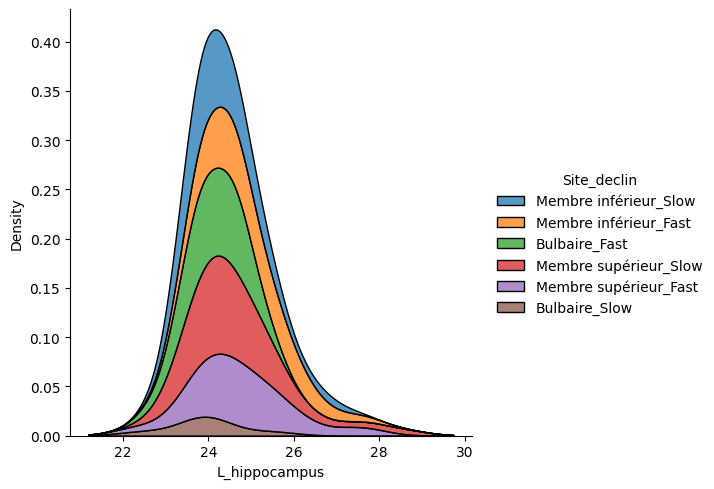

In [19]:
# Visualisation de la différence de distribution de la variable "amygdale" entre les classes de "declin"
sns.displot(data=df, x="L_hippocampus", hue="Site_declin", kind="kde", multiple="stack")

<Axes: xlabel='Declin', ylabel='Score_de_declin'>

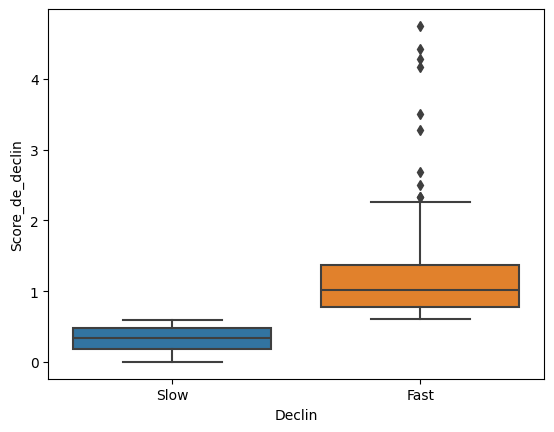

In [22]:
sns.boxplot(x="Declin", y="Score_de_declin", data=df_part)

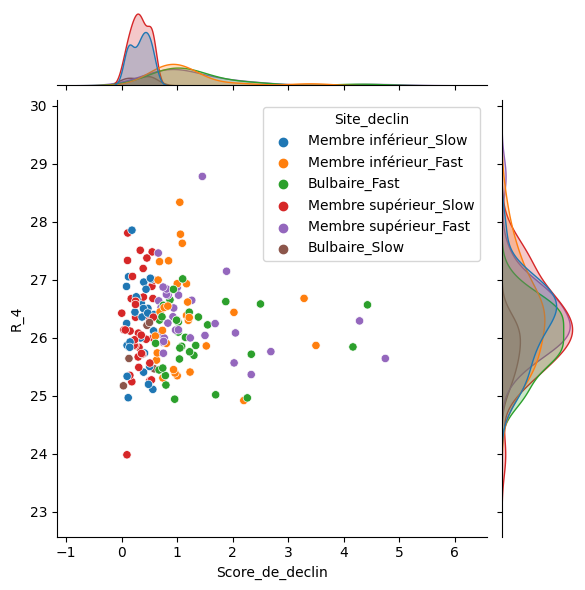

In [28]:
sns.jointplot(x='Score_de_declin',y='R_4', data=df, color='red', hue = 'Site_declin')